In [10]:
!pip install -q -U kaggle_environments

In [123]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

In [124]:
%%writefile rock_only.py

# Returns only a rock (0)
def rock_only_agent(observation, configuration):
    return 0

Writing rock_only.py


In [125]:
%%writefile paper_only.py

# Returns only a paper  (1)
def paper_only_agent(observation, configuration):
    return 1

Writing paper_only.py


In [126]:
%%writefile scissors_only.py

# Returns only a scissors (2)
def scissors_only_agent(observation, configuration):
    return 2

Writing scissors_only.py


In [127]:
%%writefile random_action.py

import random


# Returns random action
def random_action_agent(observation, configuration):
    return random.randrange(0, configuration.signs)

Writing random_action.py


In [128]:
%%writefile rock_or_paper.py

import random


# Returns rock or paper (0 or 1)
def rock_or_paper_agent(observation, configuration):
    return random.choice([0, 1])

Writing rock_or_paper.py


In [129]:
%%writefile rock_or_scissors.py

import random


# Returns rock or scissors (0 or 2)
def rock_or_scissors_agent(observation, configuration):
    return random.choice([0, 2])

Writing rock_or_scissors.py


In [130]:
%%writefile paper_or_scissors.py

import random


# Returns paper or scissors (1 or 2)
def paper_or_scissors_agent(observation, configuration):
    return random.choice([1, 2])

Writing paper_or_scissors.py


In [131]:
%%writefile enumerated_action.py

last_action = None


def enumerated_action_agent(observation, configuration):
    global last_action
    # If this is the first round, return first action
    if observation.step == 0:
        last_action = 0
    # Otherwise return next action. If previous action was the last possible, return first.
    else:
        last_action = (last_action + 1) % configuration.signs
        
    return last_action

Writing enumerated_action.py


In [132]:
%%writefile enumerated_oppenent_action.py

import random


def enumerated_oppenent_action_agent(observation, configuration):
    # If this is the first round, return random action
    if observation.step == 0:
        return random.randrange(0, configuration.signs)
    # Otherwise return next action for opponent's previous action
    else:
        return (observation.lastOpponentAction + 1) % configuration.signs

Writing enumerated_oppenent_action.py


In [133]:
%%writefile three_times_is_a_charm.py

import random


last_action = None
last_action_count = None


def three_times_is_a_charm_agent(observation, configuration):
    global last_action
    global last_action_count
    # Return previous action if it wasn't repeated more than 3 times
    if observation.step > 0 and last_action_count < 3:
        last_action_count += 1
    # If it's a first round, or action was repeated more than 3 times, change the action to random
    else:  
        last_action_count = 1
        last_action = random.choice([i for i in range(0, configuration.signs) 
                                     if observation.step == 0 or i != last_action])
        
    
    return last_action

Writing three_times_is_a_charm.py


In [134]:
%%writefile copy_opponent.py

import random


def copy_opponent_agent(observation, configuration):
    # If this is not the first round, return your opponent's last action
    if observation.step > 0:
        return observation.lastOpponentAction
    # If it's a first round, return random action
    else:
        return random.randrange(0, configuration.signs)

Writing copy_opponent.py


In [135]:
%%writefile do_not_copy_opponent.py

import random


# Returns a random action that does not copy opponent's last action
def do_not_copy_opponent_agent(observation, configuration):
    return random.choice([i for i in range(0, configuration.signs) 
                          if observation.step == 0 or i != observation.lastOpponentAction])

Writing do_not_copy_opponent.py


In [136]:
%%writefile do_not_repeat_yourself.py

import random


last_action = None


# Returns a random action that does not copy your last action
def do_not_repeat_yourself_action_agent(observation, configuration):
    global last_action
    last_action = random.choice([i for i in range(0, configuration.signs) 
                                 if observation.step == 0 or i != last_action])
        
    return last_action

Writing do_not_repeat_yourself.py


In [137]:
%%writefile do_not_copy_anyone.py

import random


last_action = None


# Returns a random action that does not copy your last action nor your opponent's last action
def do_not_copy_anyone_agent(observation, configuration):
    global last_action
    last_action = random.choice([i for i in range(0, configuration.signs) 
                          if observation.step == 0 
                                 or (i != last_action and i != observation.lastOpponentAction)])
        
    return last_action

Writing do_not_copy_anyone.py


In [138]:
%%writefile repeat_winning_action.py

import random
from kaggle_environments.envs.rps.utils import get_score


last_winning_action = None


def repeat_winning_action_agent(observation, configuration):
    global last_winning_action
    # If it's a first round, return random action
    if observation.step == 0:
        last_winning_action = random.randrange(0, configuration.signs)
    # Otherwise return last winning action
    elif get_score(last_winning_action, observation.lastOpponentAction) == -1:
        last_winning_action = observation.lastOpponentAction

    return last_winning_action

Writing repeat_winning_action.py


In [139]:
%%writefile repeat_until_loose.py

import random
from kaggle_environments.envs.rps.utils import get_score


last_action = None


def repeat_until_loose_agent(observation, configuration):
    global last_action
    # If it's a first round, return random action
    if observation.step == 0:
        last_action = random.randrange(0, configuration.signs)
    # If last round was lost return other action, otherwise do not change it
    elif get_score(last_action, observation.lastOpponentAction) == -1:
        last_action = random.choice([i for i in range(0, configuration.signs) 
                                     if i != last_action])

    return last_action

Writing repeat_until_loose.py


In [140]:
%%writefile repeat_until_tie.py

import random
from kaggle_environments.envs.rps.utils import get_score


last_action = None


def repeat_until_tie_agent(observation, configuration):
    global last_action
    # If it's a first round, return random action
    if observation.step == 0:
        last_action = random.randrange(0, configuration.signs)
    # If last round was draw return other action, otherwise do not change it
    elif get_score(last_action, observation.lastOpponentAction) == 0:
        last_action = random.choice([i for i in range(0, configuration.signs) 
                                     if i != last_action])

    return last_action

Writing repeat_until_tie.py


In [141]:
%%writefile least_used_action.py

import random


action_count = None
last_action = None


def least_used_action_agent(observation, configuration):
    global last_action
    global action_counts
    
    # If this is the first round, initialize the list with the counts and return a random action
    if observation.step == 0:
        action_counts = [0] * configuration.signs
        last_action = random.randrange(0, configuration.signs)
    else:
        # Update the counts using the data from the previous step
        action_counts[last_action] += 1
        action_counts[observation.lastOpponentAction] += 1
        # Create a list of the equal least used actions
        min_count = min(action_counts)
        actions_to_include = [i for i in range(0, len(action_counts)) 
                              if min_count == action_counts[i]]
        # Randomly choose on of the least used actions
        last_action = random.choice(actions_to_include)
    
    return last_action

Writing least_used_action.py


In [142]:
%%writefile most_winning_action.py

import random
from kaggle_environments.envs.rps.utils import get_score


action_statistics = None
last_action = None


def most_winning_action_agent(observation, configuration):
    global last_action
    global action_statistics
    
    # If this is the first round, initialize the list with the stats and return a random action
    if observation.step == 0:
        action_statistics = [0] * configuration.signs
        last_action = random.randrange(0, configuration.signs)
    else:
        # Update stats using the data from the previous step
        last_score = get_score(last_action, observation.lastOpponentAction)
        if last_score == 1:
            action_statistics[last_action] += 2
        elif last_score == -1:
            action_statistics[observation.lastOpponentAction] += 2
        # Avoid locking in case of draw
        elif last_score == 0 and action_statistics[last_action] > 0:
            action_statistics[last_action] -= 1
        # Create a list of the equal most winning actions
        max_count = max(action_statistics)    
        actions_to_include = [i for i in range(0, len(action_statistics))
                              if max_count == action_statistics[i]]
        # Randomly choose on of the most winning actions
        last_action = random.choice(actions_to_include)
    
    return last_action

Writing most_winning_action.py


In [145]:
env = make("rps", configuration={
  "episodeSteps": 100
})

In [ ]:
env.run(["rock_only.py", "rock_only.py"])

In [ ]:
env.render(mode="ipython", width=500, height=400)

In [146]:
agents = ["rock_only.py", "paper_only.py", "scissors_only.py",
          "rock_or_paper.py", "rock_or_scissors.py", "paper_or_scissors.py",
          "random_action.py", "enumerated_action.py", "enumerated_oppenent_action.py", 
          "three_times_is_a_charm.py", "copy_opponent.py", "do_not_copy_opponent.py", 
          "do_not_repeat_yourself.py", "do_not_copy_anyone.py", "repeat_winning_action.py", 
          "repeat_until_loose.py", "repeat_until_tie.py", "least_used_action.py", 
          "most_winning_action.py"]

In [147]:
agents_count = len(agents)
score_table = np.zeros((agents_count, agents_count), dtype=int)

for i in range(agents_count):
    print("Evaluating", agents[i])
    for j in range(agents_count):
        score = evaluate("rps", [agents[i], agents[j]], configuration={"episodeSteps": 1000})
        score_table[i, j] = score[0][0]
        
print("Done")

Evaluating rock_only.py
Evaluating paper_only.py
Evaluating scissors_only.py
Evaluating rock_or_paper.py
Evaluating rock_or_scissors.py
Evaluating paper_or_scissors.py
Evaluating random_action.py
Evaluating enumerated_action.py
Evaluating enumerated_oppenent_action.py
Evaluating three_times_is_a_charm.py
Evaluating copy_opponent.py
Evaluating do_not_copy_opponent.py
Evaluating do_not_repeat_yourself.py
Evaluating do_not_copy_anyone.py
Evaluating repeat_winning_action.py
Evaluating repeat_until_loose.py
Evaluating repeat_until_tie.py
Evaluating least_used_action.py
Evaluating most_winning_action.py
Done


In [148]:
df_score_table = pd.DataFrame(score_table, index=agents, columns=agents)

In [149]:
df_score_table

,rock_only.py,paper_only.py,scissors_only.py,rock_or_paper.py,rock_or_scissors.py,paper_or_scissors.py,random_action.py,enumerated_action.py,enumerated_oppenent_action.py,three_times_is_a_charm.py,copy_opponent.py,do_not_copy_opponent.py,do_not_repeat_yourself.py,do_not_copy_anyone.py,repeat_winning_action.py,repeat_until_loose.py,repeat_until_tie.py,least_used_action.py,most_winning_action.py
rock_only.py,0,-999,999,-500,485,-27,0,0,-999,33,0,0,28,0,0,0,-999,0,-991
paper_only.py,999,0,-999,507,31,-504,30,0,-997,0,0,52,20,0,0,-997,999,0,-990
scissors_only.py,-999,999,0,45,-473,504,-21,0,-999,0,0,88,0,0,-999,0,-999,0,-994
rock_or_paper.py,498,-474,0,-20,239,-262,-43,0,-268,25,0,0,0,0,-504,-508,26,0,-506
rock_or_scissors.py,-509,0,496,-258,22,233,0,50,-231,-26,0,25,0,0,-519,-482,0,0,-492
paper_or_scissors.py,-31,509,-483,219,-282,0,0,0,-229,0,0,25,0,0,-523,-500,0,-26,-521
random_action.py,0,35,46,0,0,-32,-24,0,-29,0,-23,0,-77,-20,22,100,0,28,37
enumerated_action.py,0,0,0,0,0,-33,24,0,0,0,998,-497,0,-998,999,666,-338,-240,186
enumerated_oppenent_action.py,997,998,999,230,237,245,0,0,0,508,-999,0,-474,-340,500,251,988,-73,403
three_times_is_a_charm.py,0,-60,21,0,0,0,-24,0,-497,-48,0,0,-23,0,-147,-264,36,0,0


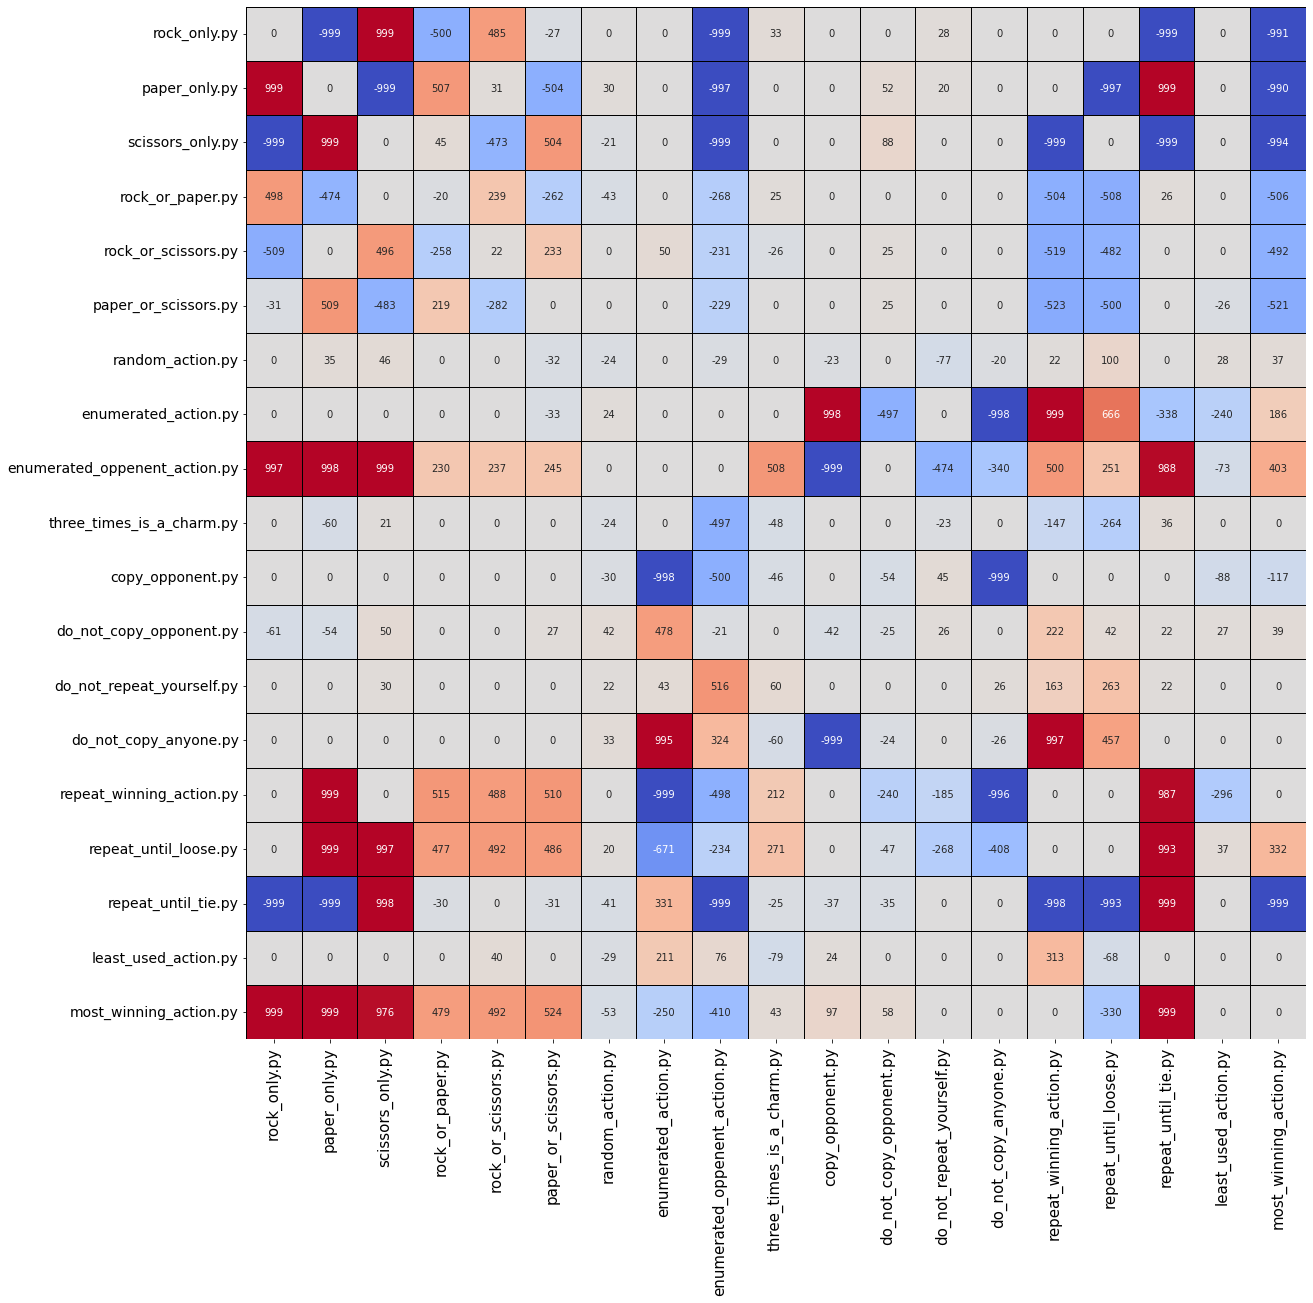

In [150]:
plt.figure(figsize=(agents_count, agents_count))
sns.heatmap(
    df_score_table, annot=True, cbar=False, 
    cmap="coolwarm", linewidths=1, 
    linecolor="black", fmt="d",
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=14);